In [1]:
import os
import sys
import yaml
import math
import itertools

module_path = os.path.abspath(os.path.join('../../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from collections import defaultdict

from bson.objectid import ObjectId
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

from src.utils.sacred_retrieval import SacredExperimentAccess, get_dicts_key_subset, get_unique_dicts, flatten_dict
from experiments.dispatch.dispatch_utils import nested_dict_to_option_strings

# plotting
# %config InlineBackend.figure_formats = ['svg']
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import pickle

# Normal PVI first

## note - there was an issue with these experiments!, they don't show up as complete! for this reason, the artifacts did not save, cannot get t_i

In [2]:
with open('../../experiment_configs/datapoint_inhomo/PVI_inhomo_baselines_two.yaml', 'r') as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)

database = experiment_config["database"]
experiment_config = flatten_dict(experiment_config)

remove_list = []
for k, v in experiment_config.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config.pop(k)

print(f"Searched config options {experiment_config}")

all_options = nested_dict_to_option_strings(experiment_config)
product = itertools.product(*all_options)
adult_configs = [dict(item) for item in product]

Searched config options {'dataset_dist.inhomo_scale': [0, 2, 4], 'optimisation_settings.N_steps': [25, 50, 100]}


In [8]:
results_access = SacredExperimentAccess(database_name=database)
betas = experiment_config['dataset_dist.inhomo_scale']
Ts = experiment_config['optimisation_settings.N_steps']

adult_grid_experiments = [results_access.get_experiments(name='jalko2017_pure_PVI', complete=True, config=config) for config in adult_configs]

adult_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_grid_experiments]

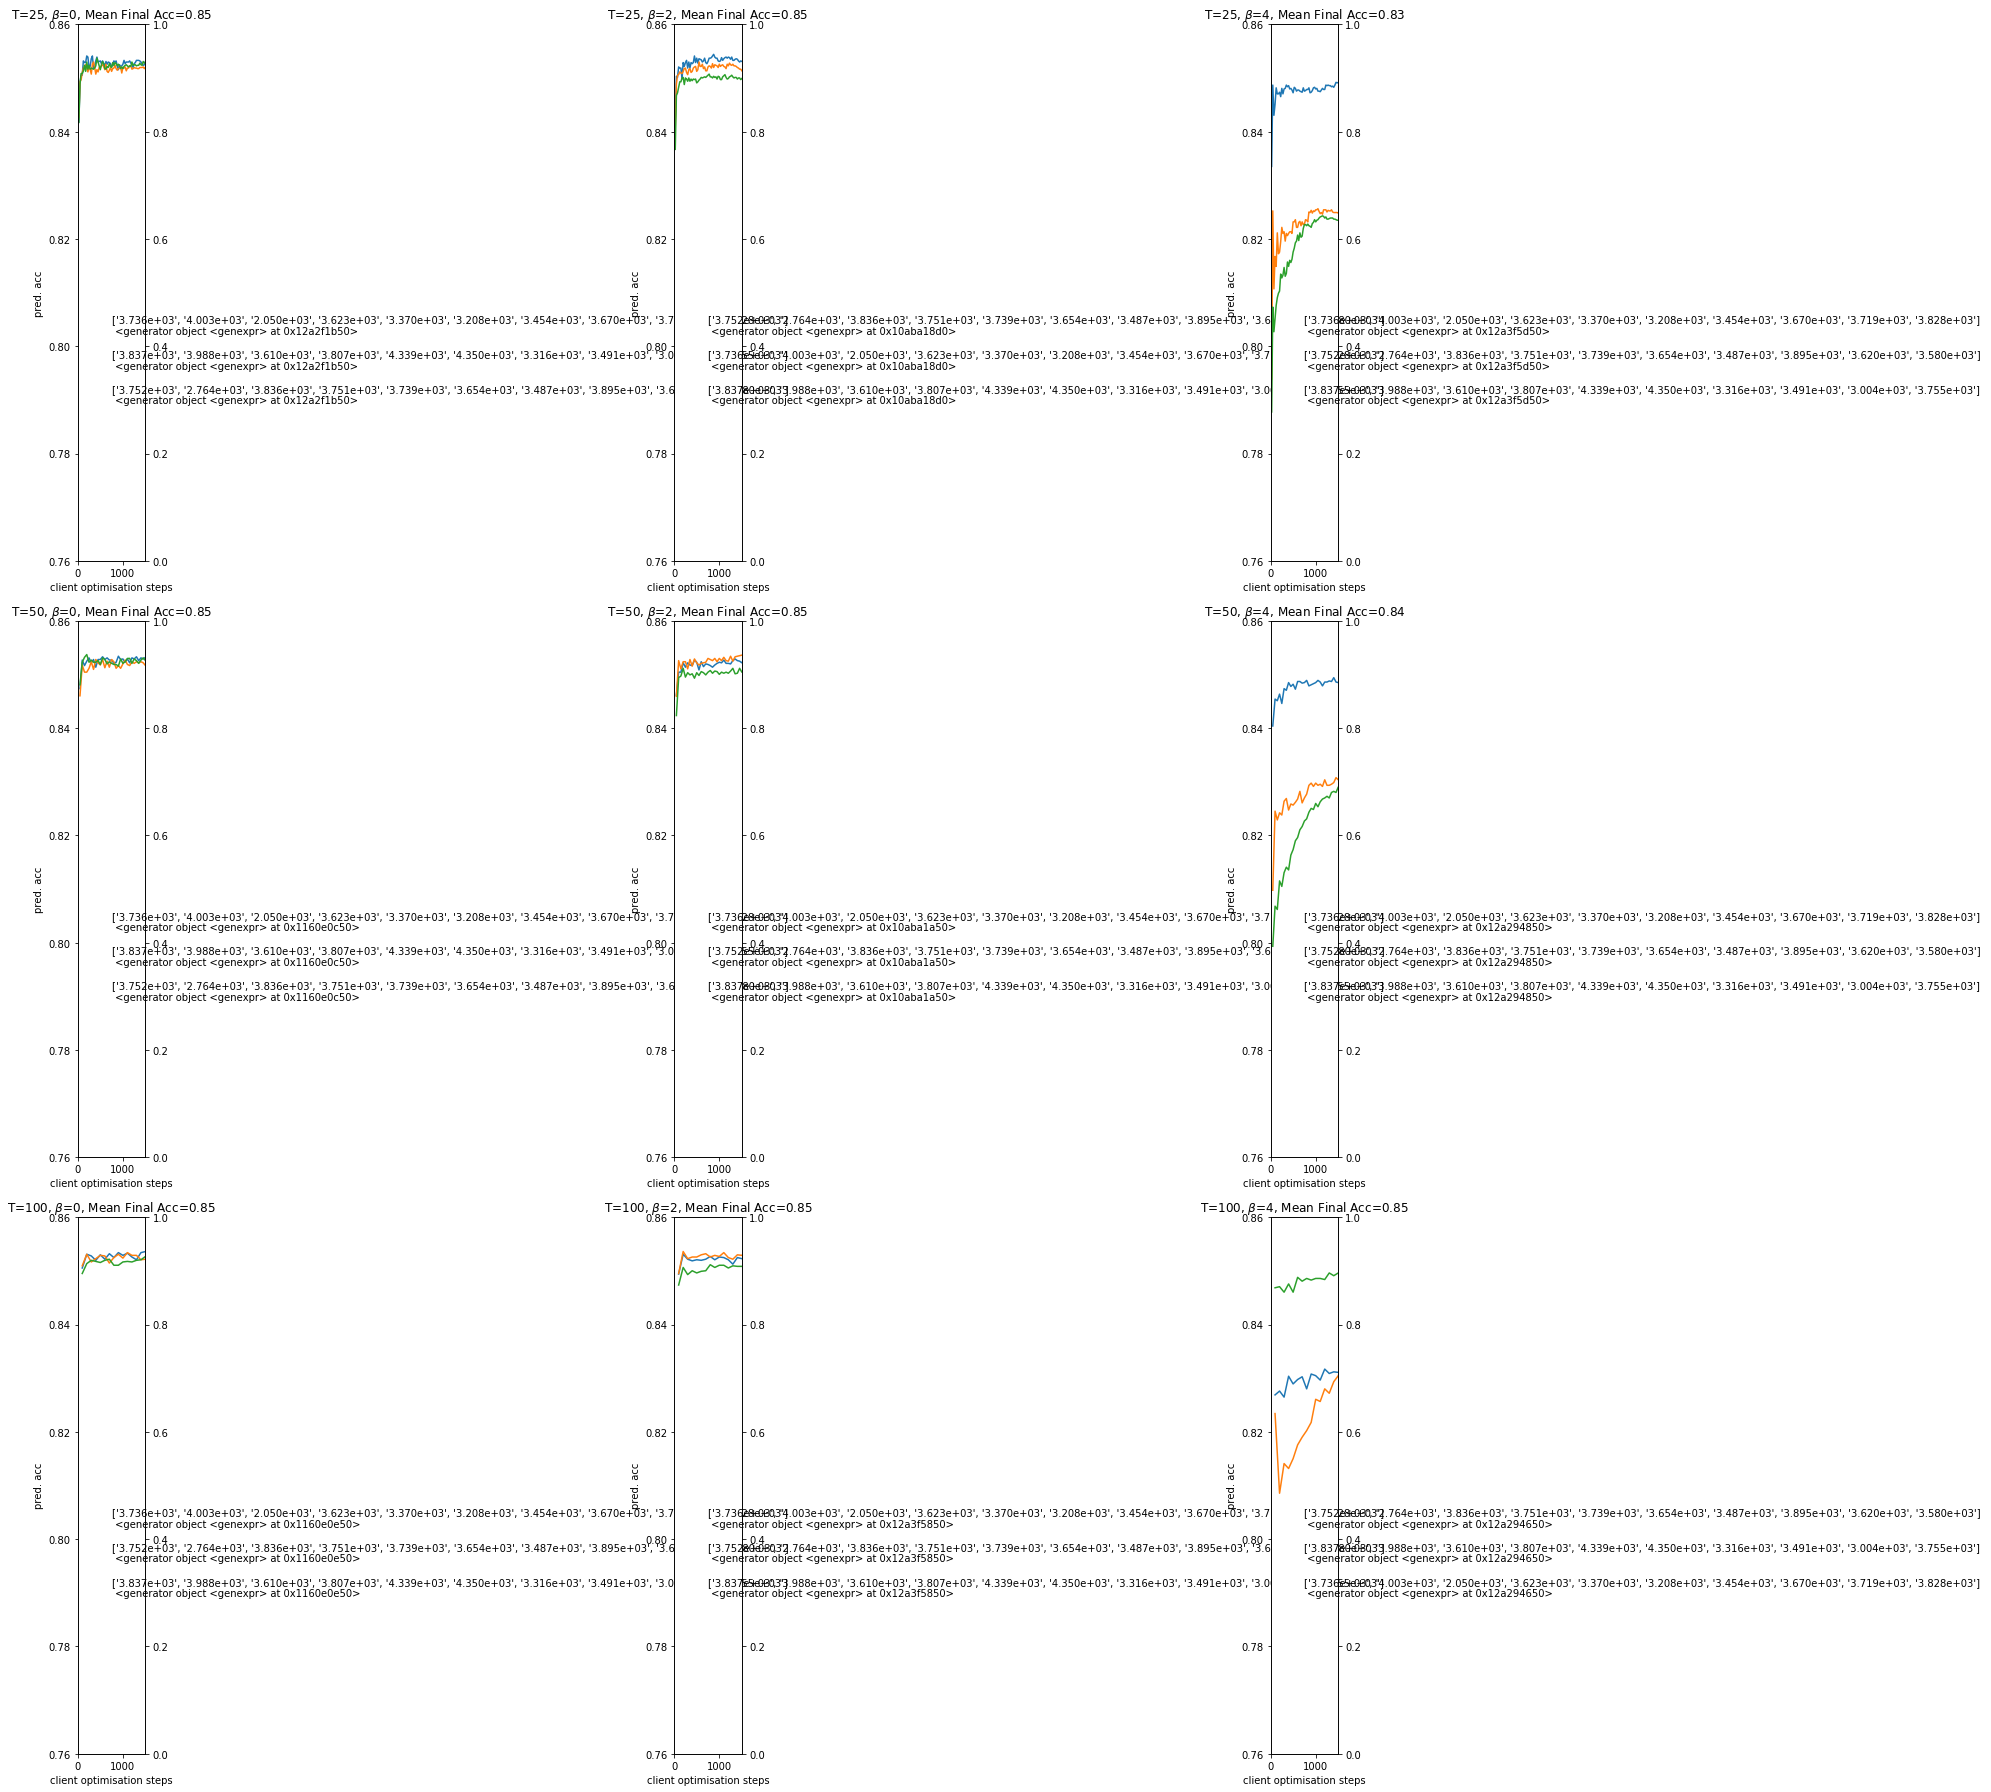

In [24]:
plt.figure(figsize=(25,25))
rows = len(Ts)
cols = len(betas)

for config, experiments, metrics in zip(adult_configs, adult_grid_experiments, adult_grid_metrics):
    T = config['optimisation_settings.N_steps']
    beta = config['dataset_dist.inhomo_scale']
    
    T_index = Ts.index(T)
    beta_index = betas.index(beta)
    
    axes = plt.subplot(rows, cols, T_index * cols + beta_index + 1)
    
    information_string = ""
    for experiment in experiments:
        information_string = information_string + f"{[f'{x:.3e}' for x in experiment['info']['n_is']]} \n {f'{x:.3e}' for x in experiment['info']['prop_positive']}\n\n"
    
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T * T
    
    
    axes2 = axes.twinx()
    plt.text(0.5, 0.25, information_string, transform=axes.transAxes)
    plt.title(f"T={T}, $\\beta$={beta}, Mean Final Acc={np.mean(values[-1]):.2f}")
    
    axes.plot(steps, values)
    axes.set_xlabel('client optimisation steps')
    axes.set_ylabel('pred. acc')
    plt.xlim([0, 1500])
    axes.set_ylim(0.76, 0.86)
    
plt.tight_layout()

perhaps the initial damping was not strong enough? at least they all work with PVI

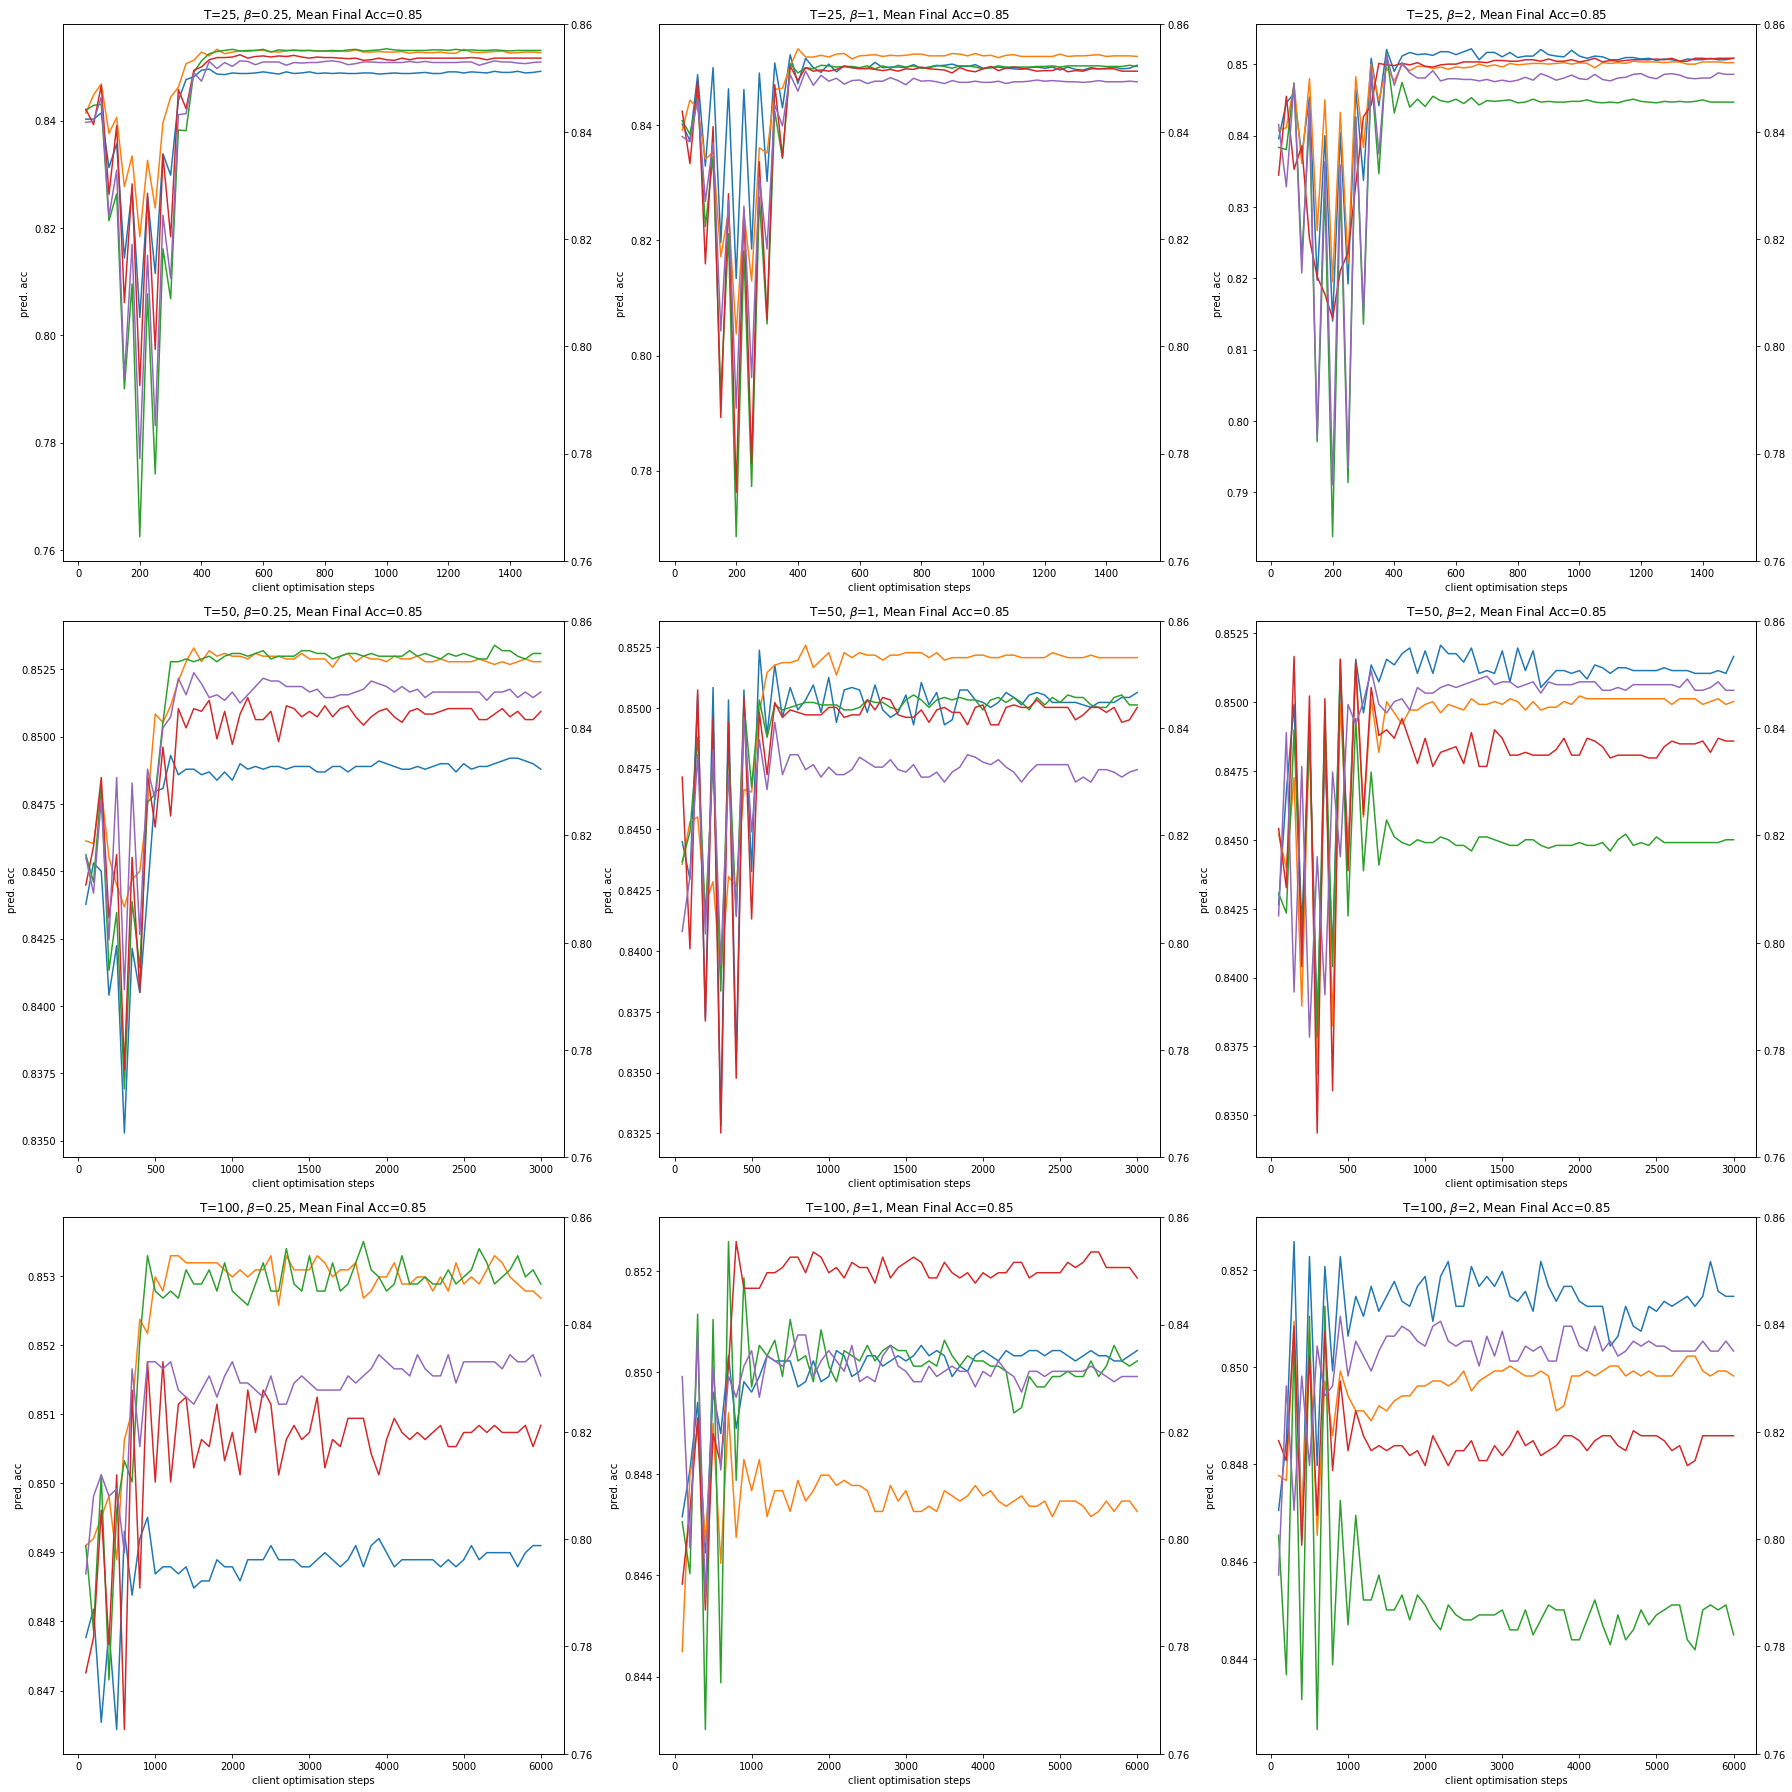

In [14]:
results_access = SacredExperimentAccess(database_name=database)
betas = experiment_config['dataset_dist.inhomo_scale']
Ts = experiment_config['optimisation_settings.N_steps']

adult_grid_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=False, config=config) for config in adult_configs]

adult_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_grid_experiments]

plt.figure(figsize=(25,25))
rows = len(Ts)
cols = len(betas)

for config, experiments, metrics, eps_metrics in zip(adult_configs, adult_grid_experiments, adult_grid_metrics, adult_eps_metrics):
    T = config['optimisation_settings.N_steps']
    beta = config['dataset_dist.inhomo_scale']
    
    T_index = Ts.index(T)
    beta_index = betas.index(beta)
    
    axes = plt.subplot(rows, cols, T_index * cols + beta_index + 1)
    
    
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T * T
    
    
    axes2 = axes.twinx()
    
    plt.title(f"T={T}, $\\beta$={beta}, Mean Final Acc={np.mean(values[-1]):.2f}")
    
    axes.plot(steps, values)
    axes.set_xlabel('client optimisation steps')
    axes.set_ylabel('pred. acc')
    plt.ylim([0.76, 0.86])
    
plt.tight_layout()

# Try DP-PVI

In [90]:
with open('../../experiment_configs/datapoint_inhomo/datapoint_inhomo.yaml', 'r') as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)

database = experiment_config["database"]
experiment_config = flatten_dict(experiment_config)

remove_list = []
for k, v in experiment_config.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config.pop(k)

print(f"Searched config options {experiment_config}")

all_options = nested_dict_to_option_strings(experiment_config)
product = itertools.product(*all_options)
adult_configs = [dict(item) for item in product]

Searched config options {'dataset_dist.inhomo_scale': [0.25, 1, 2], 'optimisation_settings.N_steps': [25, 50, 100]}


In [95]:
results_access = SacredExperimentAccess(database_name=database)
betas = experiment_config['dataset_dist.inhomo_scale']
Ts = experiment_config['optimisation_settings.N_steps']

adult_grid_experiments = [results_access.get_experiments(name='jalko2017_datapoint_exp', complete=False, config=config) for config in adult_configs]

adult_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_grid_experiments]
adult_eps_metrics = [results_access.get_metrics_by_exp(experiments, "epsilon", "in") for experiments in adult_grid_experiments]

plt.figure(figsize=(25,25))
rows = len(Ts)
cols = len(betas)

for config, experiments, metrics, eps_metrics in zip(adult_configs, adult_grid_experiments, adult_grid_metrics, adult_eps_metrics):
    T = config['optimisation_settings.N_steps']
    beta = config['dataset_dist.inhomo_scale']
    
    T_index = Ts.index(T)
    beta_index = betas.index(beta)
    
    axes = plt.subplot(rows, cols, T_index * cols + beta_index + 1)
    
    
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T * T
    
    seed_eps_values = []
    for seed_indx, seed_eps in enumerate(eps_metrics):
        eps_values = []
        for client_eps in seed_eps:
            eps_values.append(np.array(client_eps["values"]).flatten())
        eps_values = np.array(eps_values)
        seed_eps_values.append(np.mean(eps_values, 0))
    
    final_mean_eps_values = np.mean(seed_eps_values, 0)
    
    axes2 = axes.twinx()
    
    plt.title(f"T={T}, $\\beta$={beta}, Mean Final Acc={np.mean(values[-1]):.2f}")
    
    axes.plot(steps, values)
    axes.set_xlabel('client optimisation steps')
    axes.set_ylabel('pred. acc')
    axes2.plot(steps, final_mean_eps_values, '--')
    axes2.set_ylabel('$\epsilon$')
    axes2.set_ylim(0.25, 3.25)
    plt.xlim([0, 1500])
    axes.set_ylim(0.76, 0.86)
    
plt.tight_layout()

# Lets look at the tis

In [88]:
def to_mean_var(nat_1, nat_2):
    nat_1[nat_2 == 0] = 0
    nat_2[nat_2 == 0] = 1
    return nat_1 / nat_2, np.log(1 / nat_2)

def compute_KL_qp(q_mean, q_log_var_diag, p_mean, p_log_var_diag):
    q_var = np.diag(np.exp(q_log_var_diag))
    p_var = np.diag(np.exp(p_log_var_diag))
    k = q_mean.shape[0]
    p_inv = np.linalg.inv(p_var)
    m1_m2 = p_mean - q_mean
    # note that we a-priori know that q_var is a diagonal matrix
    KL = 0.5 * (np.trace(p_inv @ q_var) + np.dot(m1_m2, p_inv @ m1_m2) - k + np.sum(
        p_log_var_diag) - np.sum(q_log_var_diag))
    
#     print("A", np.trace(p_inv @ q_var))
#     print("B", np.dot(m1_m2, p_inv @ m1_m2))
#     print("C",np.sum(p_log_var_diag))
#     print("D",np.sum(q_log_var_diag))
    return KL

plt.figure(figsize=(25,25))

for config, experiments, metrics in zip(adult_configs, adult_grid_experiments, adult_grid_metrics):
    T = config['optimisation_settings.N_steps']
    beta = config['dataset_dist.inhomo_scale']
    
    T_index = Ts.index(T)
    beta_index = betas.index(beta)
    
    num_seeds = len(experiments)
    all_kl_matrics = np.zeros((num_seeds, M, M))
    for ind, seed in enumerate(experiments):
        t_is = pickle.loads(results_access.get_artifacts_by_id( [seed["artifacts"][1]["file_id"]])[0])
        kl_vals = np.zeros((M, M))
        for i in range(M):
            for j in range(M):
                mean_a, log_var_a = to_mean_var(t_is[i]["w_nat_mean"],t_is[i]["w_pres"])
                mean_b, log_var_b = to_mean_var(t_is[j]["w_nat_mean"],t_is[j]["w_pres"])
                kl = compute_KL_qp(mean_a, log_var_a, mean_b, log_var_b)
#                 print(kl)
                kl_vals[i][j] = kl
        all_kl_matrics[ind] = kl_vals
    mean_kl_matrics = np.log(np.mean(all_kl_matrics, 0))
    
    axes = plt.subplot(rows, cols, T_index * cols + beta_index + 1)
    plt.imshow(mean_kl_matrics, cmap="hot")
    plt.title(f"T={T}, $\\beta$={beta}, Mean Final Acc={np.mean(values[-1]):.2f}, Mean log kl = {np.log(np.mean(all_kl_matrics)):.2f}")

plt.tight_layout()

/Users/msharma/.local/share/virtualenvs/DP-PVI-jh1H6qk4/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log


In [7]:
print(metrics)

[]
